### Battery Classification: Logistic Regression for Multi-Class Chemistry Classification


In this notebook we will explore logistic regression as a classification method to predict different chemistries based on the input training features. Binary classifiers use a sigmoid function to predict between two classes. Since we have 4 chemistries to consider, we'll replace the sigmoid with a soft-max function such that the combined probabilities of all classes adds up to 1.  

We'll get started by importing our packages.

In [4]:
#Import packages
import os 
import numpy as np 
import pandas as pd 
from scipy.stats import uniform, randint

#ML packages
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import LeaveOneOut, RandomizedSearchCV


#Visualization packages
import matplotlib.pyplot as plt
import seaborn as sns




Now we'll load the dataset for model training, since we've demonstrated this in the prior notebook, we'll copy over the relavent code in the cell below....

In [3]:

def summarize_features(input_df, chemistry, chemistry_filepath, desired_features):
    """This function takes the input_features and finds the mean, min, max and standard deviation for each of them,
    returning a dataframe of the aggregated features for each unique battery, along with its chemistry. 
    Inputs: input_df (pandas dataframe), chemistry (str), chemistry_filepath (str), and desired_features (list)
    Outputs: agg_data (pandas dataframe)"""

    tdf = input_df[desired_features]

    agg_data = {}
    for col in tdf.columns:
        agg_data[f"{col}_mean"] = tdf[col].mean()
        agg_data[f"{col}_std"] = tdf[col].std()
        agg_data[f"{col}_min"] = tdf[col].min()
        agg_data[f"{col}_max"] = tdf[col].max()
    
    # Add metadata
    agg_data["chemistry"] = chemistry
    agg_data["file"] = chemistry_filepath
    return agg_data


def agg_chem_features(input_dir): 
    """This function walks through an input directory, finds each chemistry folder and the battery id 
    folders embedded in each of them. For each battery ID, it reads the file to a dataframe and 
    aggregates the desired features using summarize features.  
    Inputs: input_dir (str)
    Outputs: result_df (pandas dataframe)"""

    chemistries = os.listdir(input_dir)
    desired_features = ["cycle_index","normalized_time","voltage_v", "c_rate","temperature_k"]
    all_data = []
    for chemistry in chemistries:
        chemistry_path = os.path.join(input_dir, chemistry)
        for chemistry_folder in os.listdir(chemistry_path):
            chemistry_filepath = os.path.join(chemistry_path, chemistry_folder)
            chemistry_filepath_dir = os.listdir(chemistry_filepath)
            desired_files = [temp_file for temp_file in chemistry_filepath_dir if "error_log" not in temp_file]
            
            charge_filepath = None
            discharge_filepath = None

            for file in desired_files: 
                if "discharge" in file:
                    discharge_filepath = os.path.join(chemistry_filepath, file)
                elif "charge" in file: 
                    charge_filepath = os.path.join(chemistry_filepath, file)
                    
            # Only proceed if both files were found
            if not (charge_filepath and discharge_filepath):
                continue
                
            # Read the file for charge and discharge 
            charge_df = pd.read_csv(charge_filepath)
            discharge_df = pd.read_csv(discharge_filepath)
            if len(charge_df) > 0 and len(discharge_df)>0: 
                if charge_df.c_rate.iloc[0] == "variable" or discharge_df.c_rate.iloc[0] == "variable": 
                    continue 
                else: 
                    charge_data = summarize_features(charge_df, chemistry, charge_filepath, desired_features)
                    discharge_data = summarize_features(discharge_df, chemistry, discharge_filepath, desired_features)

                    # Convert dicts to DataFrames for concat
                    charge_data = pd.DataFrame([charge_data])
                    discharge_data = pd.DataFrame([discharge_data])

                    # Add column naming to distinguish between charge and discharge
                    charge_data.columns = ['charge_' + col if col not in ['chemistry', 'file'] else col for col in charge_data.columns]
                    discharge_data.columns = ['discharge_' + col if col not in ['chemistry', 'file'] else col for col in discharge_data.columns]

                    combined_df = pd.concat([charge_data, discharge_data], axis=1)  # ✅ axis=1 to combine horizontally
                    all_data.append(combined_df)
    
    # Combine all per-file aggregates
    result_df = pd.concat(all_data, ignore_index=True)  # ✅ concat instead of DataFrame(list_of_dfs)
    return result_df


def scrub_values(input_df): 
    """This function takes the input dataframe and removes any features from the dataframe if they are found 
     in the pre-specified strip_cols list, ultimately returning the subset feature dataframe.  
    Inputs: input_df (pandas dataframe)
    Outputs: strip_df (pandas dataframe)"""

    #Now let's remove unneeded features: 
    strip_cols = ['charge_cycle_index_min', 'charge_cycle_index_max', 'charge_cycle_index_mean', 'charge_cycle_index_std',
                'charge_normalized_time_min', 'charge_normalized_time_max', 'discharge_c_rate_min', 'discharge_c_rate_max',
                'discharge_c_rate_std', 'charge_c_rate_min', 'charge_c_rate_max', 'charge_c_rate_std', 
                'discharge_temperature_k_max', 'discharge_temperature_k_min', 'discharge_temperature_k_std',
                'charge_temperature_k_max', 'charge_temperature_k_min', 'charge_temperature_k_std', 
                'discharge_temperature_k_mean', 'file', 'discharge_cycle_index_mean', 'discharge_cycle_index_max',
                'discharge_cycle_index_min', 'discharge_cycle_index_std',
                'discharge_normalized_time_max', 'discharge_normalized_time_min', 'discharge_normalized_time_std',
                'charge_normalized_time_std', 'charge_normalized_time_mean', 'discharge_normalized_time_mean']

    strip_df = input_df.drop(columns=strip_cols, errors='ignore')
    strip_df = strip_df.iloc[:, :-1]
    strip_df.describe()
    return strip_df


input_dir = r'..\assets\processed'
print('Generating initial training data')
result_df = agg_chem_features(input_dir)
print('Removing unwanted features')
strip_df = scrub_values(result_df)
print('Here is a quick overview:')
strip_df.sample(3)



Generating initial training data
Removing unwanted features
Here is a quick overview:


,charge_voltage_v_mean,charge_voltage_v_std,charge_voltage_v_min,charge_voltage_v_max,charge_c_rate_mean,charge_temperature_k_mean,chemistry,discharge_voltage_v_mean,discharge_voltage_v_std,discharge_voltage_v_min,discharge_voltage_v_max,discharge_c_rate_mean
141,3.520025,0.083046,3.407900,3.600155,1.0,298.0,LFP,2.795903,0.482544,1.997582,3.5864,1.0
73,3.529378,0.082533,3.296300,3.600400,1.0,298.0,LFP,2.764967,0.496605,1.998208,3.5900,1.0
142,3.524429,0.082780,3.407273,3.600188,1.0,298.0,LFP,2.795360,0.484089,1.998961,3.5863,1.0


Now we'll separate between betweeen input and output feaures, we'll train the model, and compare the confusion matrix

d:\Capstone\Battery_Classifier\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


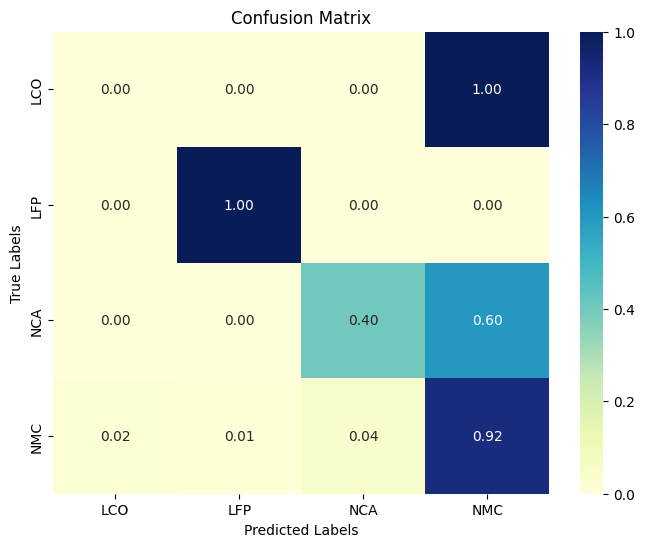

Classification Report:
              precision    recall  f1-score   support

         LCO       0.00      0.00      0.00        13
         LFP       0.98      1.00      0.99        58
         NCA       0.33      0.40      0.36         5
         NMC       0.84      0.92      0.88        90

    accuracy                           0.86       166
   macro avg       0.54      0.58      0.56       166
weighted avg       0.81      0.86      0.83       166



In [ ]:
#Split between outcome and input variables
training_column = "chemistry"
y = strip_df[training_column]
X = strip_df.drop(columns=[training_column]) 

#Separate between train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=42)


#Prepare the encoder 
encoder = LabelEncoder()
y_train_encoded = encoder.fit_transform(y_train)
y_test_encoded = encoder.transform(y_test)

#Load the model 
model = LogisticRegression(solver='lbfgs', max_iter=1000)
model.fit(X_train, y_train_encoded)


predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)
# Compute confusion matrix
cm = confusion_matrix(y_test_encoded, predictions, normalize='true')

# Optional: get the class labels (in the same order used by LabelEncoder)
labels = encoder.classes_

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Print classification report too
print("Classification Report:")
print(classification_report(y_test_encoded, predictions, target_names=labels))

Examining the classifer performance we see that it does not perform well at all for LCO or NCA chemistries. We'll try a brief hyper-parameter tuning step to see it improves the model performance at all. Since we do not have many test features for the LCO and NCA classes, we'll employ leave on out encoding which effectively iterates with a single class output as the test set each time, iterating until all class outputs have been included in test at least once. By doing this we should see some level of improvement. 

In [ ]:
# Split the dataframe into our output and input features
y = strip_df[training_column]
X = strip_df.drop(columns=[training_column])

# Transform the output data for multi-class classification
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Apply scaling to the input feature set
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Setup the base logistic regression model and the sweep conditions for the hyper parameter(s)
logreg = LogisticRegression(solver='lbfgs', max_iter=1000)

param_dist = {
    'C': loguniform(1e-4, 1e2),
    'solver': ['lbfgs', 'saga']
}

# Load leave one out 
loo = LeaveOneOut()

# Setup the random search applying LeaveOneOut cross-validation
random_search = RandomizedSearchCV(
    estimator=logreg,
    param_distributions=param_dist,
    n_iter=20,
    cv=loo,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42
)

# Execute the random search
random_search.fit(X_scaled, y_encoded)

# Callout best model and its parameters
best_model = random_search.best_estimator_
print("Best parameters found:", random_search.best_params_)
print("Best cross-validation accuracy:", random_search.best_score_)

# Generate predictions based on the LOO training
predictions = best_model.predict(X_scaled)

# Examine prediction performance
print("\nClassification Report:")
print(classification_report(y_encoded, predictions, target_names=labels))

# Show the confusion matrix
cm_normalized = confusion_matrix(y_encoded, predictions, normalize='true')

plt.figure(figsize=(8,6))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='YlGnBu',
            xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix (Chemistry Classes)")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.tight_layout()
plt.show()



NameError: name 'training_column' is not defined

Finally we'll check the model size to gauge data storage requirement in deployment. Ideally the model has a low compute requirement to minimize the cost from repeatedly calling the model in the deployed AWS environment. Furthermore, we may extend the classification algorithm to physical hardware in the future, where a cost-effective solution would generally be limited to <256kb <br>source: https://pmc.ncbi.nlm.nih.gov/articles/PMC9683383/#:~:text=Table_title:%20TABLE%20I.%20Table_content:%20header:%20%7C%20Platform,SRAM%20%7C%20Storage:%2032%2D2048%20kB%20eFlash%20%7C) 

In [37]:
# Export the model and check size: 
import pickle

with open('logistic_model.pkl', 'wb') as f:
    pickle.dump(model, f)

file_path = 'logistic_model.pkl'  # or 'logistic_model.pkl'
size_bytes = os.path.getsize(file_path)
size_kb = size_bytes / 1024
size_mb = size_kb / 1024

print(f"Model size: {size_bytes} bytes ({size_kb:.2f} KB / {size_mb:.2f} MB)")
os.remove(file_path)
print(f"File '{file_path}' has been deleted.")

Model size: 1469 bytes (1.43 KB / 0.00 MB)
File 'logistic_model.pkl' has been deleted.


Great, so after applying hyper-parameter tuning with Leave-One-Out, we've substantially improved our predictive capabilities for both LCO and NCA, and we can see that the model would be small enough to economically deploy both in the AWS environment and/or on physical hardware in the future. Next, we will explore more complex modeling approaches, including random forest classification, neural network classification using continuous, tabular data, and image-based chemistry classification.